In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import matplotlib
import cv2
import os

In [2]:
#Specifying the number of classes and images to use
n_classes = 2;
n_figs = 700;

#Specifying the total number of classes and images avaialble
N_classes = 45;
N_figs = 700;

#Randomly choosing the classes and figures to analyze
class_idx = np.random.permutation(N_classes)[:n_classes];
fig_idx = np.random.permutation(N_figs)[:n_figs]
#These two lines above generate different choices each time they're executed unless the random seed is reset

In [3]:
#Specifying the path
PROJECT_ROOT_DIR = '..'
DATASET_FOLDER = 'training_data'
DATASET_PATH = os.path.join(PROJECT_ROOT_DIR,DATASET_FOLDER)
 
'''
#Reading the folders tree
classes_all = sorted(os.listdir(DATASET_PATH));
print(classes_all)
classes_all.remove('summary'); #Removes the summary file
N_classes = len(classes_all)
if n_classes > 0 and n_classes <= N_classes:
    classes = [classes_all[idx] for idx in class_idx]
else:
    print('Wrong number of classes requested')
    raise SystemExit(0)
'''

classes = ['basketball_court', 'baseball_diamond', 'railway_station', 'lake']
n_classes = len(classes)
    
#Reading the figures
figs = [];
for folder in classes:
    CLASS_PATH = os.path.join(DATASET_PATH, folder);
    figs_names_all = sorted(os.listdir(CLASS_PATH));
    if n_figs > 0 and n_figs <= N_figs:
        figs_names = [figs_names_all[idx] for idx in fig_idx]
        FIGS_PATHS = [os.path.join(CLASS_PATH, fig) for fig in figs_names]
        figs_i = [cv2.imread(PATH,0) for PATH in FIGS_PATHS]; #cv2.imread with flag 0 reads the image in grayscale
        figs.append(figs_i)
    else:
        print('Wrong number of figures requested')
        raise SystemExit(0)

In [4]:
#Shows the names of the chosen classes and their corresponding indexes in figs
print('Chosen classes:')
print(list(enumerate(classes)))

print(classes[0])

Chosen classes:
[(0, 'basketball_court'), (1, 'baseball_diamond'), (2, 'railway_station'), (3, 'lake')]
basketball_court


[[ 96  90  88 ... 123 127 130]
 [ 91  88  89 ... 101 110 118]
 [ 88  88  90 ...  84  90  95]
 ...
 [ 80  80  80 ...  77  78  80]
 [ 81  81  81 ...  75  77  80]
 [ 81  81  81 ...  74  76  79]]
(256, 256)


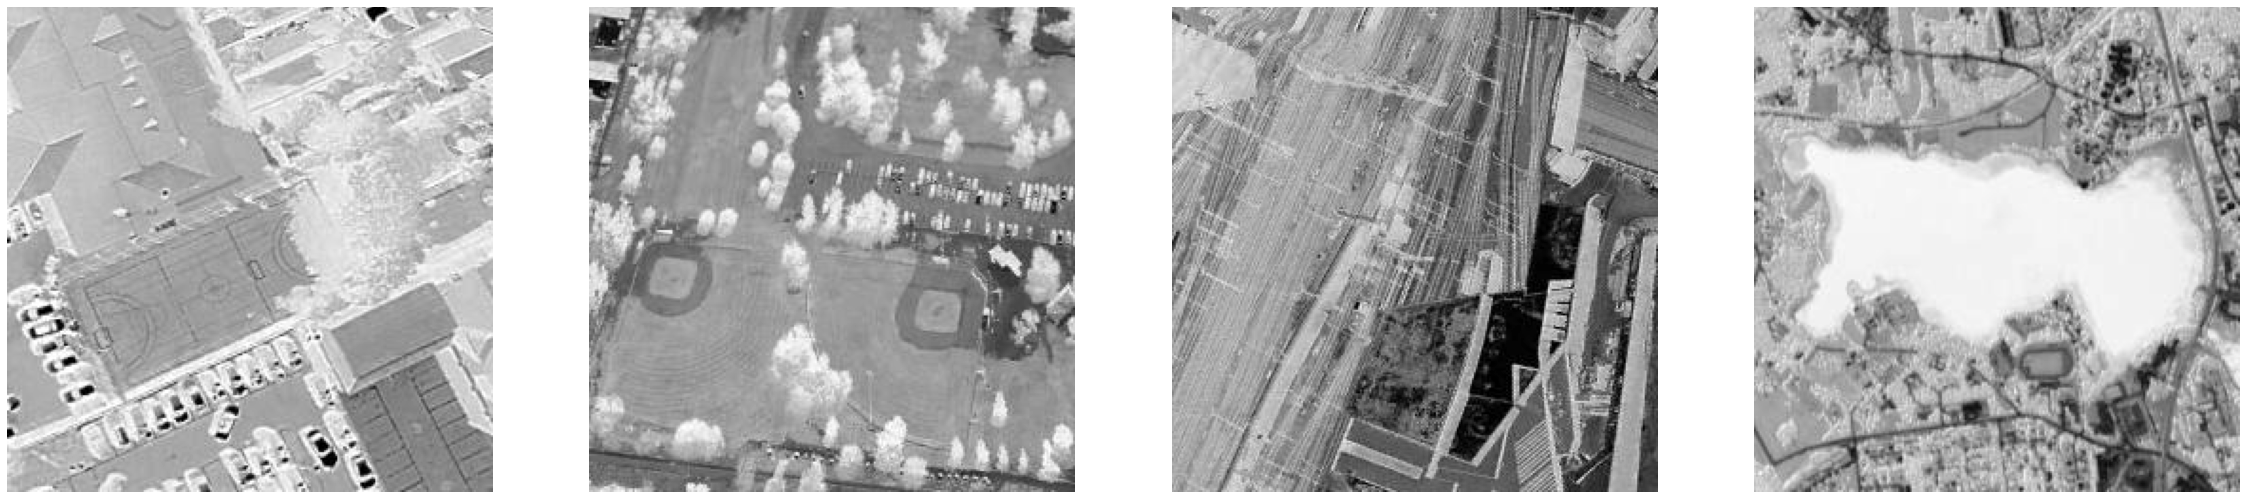

In [5]:
#Visualizing some of the data

plt.rcParams["figure.figsize"] = (40,20)  


fig_test = figs[1][2];
print(fig_test)
print(np.shape(fig_test))

for i in range(4):
    plt.subplot(1,4,i+1)
    fig_test = figs[i][0]
    plt.imshow(fig_test, cmap = matplotlib.cm.binary); plt.axis("off")

plt.savefig('./sample_images.png', format='png',bbox_inches='tight',dpi=300)   
    

In [6]:
train_split = 0.6  # must be divisible with n_figs
val_split = 0.15
test_split = 0.25


def split_data(train_split=0.6, val_split=0.15, test_split=0.25):
    
    training_data = np.empty((int(n_classes*n_figs*train_split), 256*256))
    val_data = np.empty((int(n_classes*n_figs*val_split), 256*256))
    testing_data = np.empty((int(n_classes*n_figs*test_split), 256*256))

    print(f'training size: {training_data.shape[0]}')
    print(f'validation size: {val_data.shape[0]}')
    print(f'testing size: {testing_data.shape[0]}')

    training_labels=[]
    testing_labels=[]
    val_labels=[]

    b = -1
    c = -1
    d = -1

    for i in range(n_classes):
        for j in range(n_figs):
            if j < n_figs*train_split:
                b = b+1
                training_labels.append(classes[i])
                training_data[b,:] = figs[i][j].flatten()

            elif j >= n_figs*train_split and j < n_figs*(train_split+val_split):
                c = c+1
                val_labels.append(classes[i])
                val_data[c,:] = figs[i][j].flatten()

            elif j >= n_figs*(train_split+val_split):
                d = d+1
                #testing_labels[d] = classes[i]
                testing_labels.append(classes[i])
                testing_data[d,:] = figs[i][j].flatten()

    print(b,c,d)            
    print(training_data.shape)
    #print(training_labels)

    [U, S, VH] = np.linalg.svd(training_data, full_matrices=False)

    V = VH.T
    
    return training_data, val_data, testing_data, training_labels, val_labels, testing_labels, V 

[training_data, val_data, testing_data, training_labels, val_labels, testing_labels, V] = split_data()


training size: 1680
validation size: 420
testing size: 700
1679 419 699
(1680, 65536)


(65536, 10)
(1680, 10)
(1680, 65536)


(-0.5, 255.5, 255.5, -0.5)

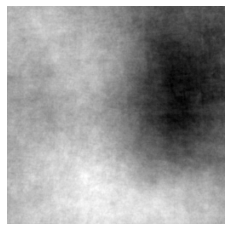

In [85]:
# check dim reduction

r = 10

Vr = V[:,0:10]

print(np.shape(Vr))

r_training_data = training_data @ Vr
r_testing_data = testing_data @ Vr
r_val_data = val_data @ Vr

print(r_training_data.shape)

reconstruct = r_training_data @ Vr.T

print(reconstruct.shape)

plt.imshow(np.reshape(reconstruct[0], (256, 256)), cmap = matplotlib.cm.binary); plt.axis("off")


(-0.5, 255.5, 255.5, -0.5)

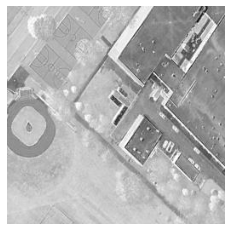

In [86]:
plt.imshow(np.reshape(training_data[0], (256,256)), cmap = matplotlib.cm.binary); plt.axis("off")

## Implementation of KNN classification

In [7]:
def l2_distance(x1, x2):
    d = np.linalg.norm(x1-x2)
    return d

def knn(test_point, training_data, training_labels, k):
    n = training_data.shape[0]
    distances = np.empty((n))
    for i in range(n):
        distances[i] = l2_distance(training_data[i,:], test_point)
    
    inds = np.argpartition(distances, k)[:k]
    labels = [training_labels[i] for i in inds]
    c = Counter(labels)
    prediction = c.most_common(1)
                            
    return prediction

# test the function
p = knn(training_data[0], training_data, training_labels, 2)#int(n_figs*train_split))
print(f'Prediction: {p[0][0]}, Truth: {testing_labels[0]} ')
                        

Prediction: basketball_court, Truth: basketball_court 


In [50]:
# test the model

n_correct = 0
for i in range(testing_data.shape[0]):
    p = knn(testing_data[i], training_data, training_labels, int(n_figs*train_split))
    #print(f'Prediction: {p[0][0]}, Truth: {testing_labels[i]} ');
    if p[0][0] == testing_labels[i]:
        n_correct = n_correct + 1
        
print(f'testing accuracy: {n_correct/testing_data.shape[0]}')
    

testing accuracy: 0.42


In [68]:
# test

kvals = [10, 20, 30, 40, 60, 80, 100, 200, 400]
accuracies = []
for k in kvals:
    n_correct = 0
    for i in range(val_data.shape[0]):
        p = knn(val_data[i], training_data, training_labels, k)
        # print(f'Prediction: {p[0][0]}, Truth: {testing_labels[i]} ')
        if p[0][0] == val_labels[i]:
            n_correct = n_correct + 1
    print(f'k = {k}, testing accuracy: {n_correct/val_data.shape[0]}')
    accuracies.append(n_correct/val_data.shape[0])        


k = 10, testing accuracy: 0.4041666666666667
k = 20, testing accuracy: 0.4166666666666667
k = 30, testing accuracy: 0.4083333333333333
k = 40, testing accuracy: 0.42083333333333334
k = 60, testing accuracy: 0.44166666666666665
k = 80, testing accuracy: 0.4375
k = 100, testing accuracy: 0.4375
k = 200, testing accuracy: 0.42916666666666664
k = 400, testing accuracy: 0.4583333333333333


In [87]:
# test the reduced dataset

rs = [5, 10, 20, 40, 100, 500, 1000]
kvals = [5, 10, 20, 40, 60, 100, 200, 400]

accuracies_all = []
for r in rs: 
    
    Vr = V[:,0:r]
    r_training_data = training_data @ Vr
    r_testing_data = testing_data @ Vr
    r_val_data = val_data @ Vr
    
    accuracies = []
    for k in kvals:
        n_correct = 0
        for i in range(r_val_data.shape[0]):
            p = knn(r_val_data[i], r_training_data, training_labels, k)
            #print(f'Prediction: {p[0][0]}, Truth: {testing_labels[i]} ')
            if p[0][0] == val_labels[i]:
                n_correct = n_correct + 1
        print(f'r = {r}, k = {k}, validation accuracy: {n_correct/r_val_data.shape[0]}')
        accuracies.append(n_correct/r_val_data.shape[0])  
    accuracies_all.append(accuracies)
    

r = 5, k = 5, validation accuracy: 0.5238095238095238
r = 5, k = 10, validation accuracy: 0.5333333333333333
r = 5, k = 20, validation accuracy: 0.5166666666666667
r = 5, k = 40, validation accuracy: 0.5095238095238095
r = 5, k = 60, validation accuracy: 0.5261904761904762
r = 5, k = 100, validation accuracy: 0.5142857142857142
r = 5, k = 200, validation accuracy: 0.49047619047619045
r = 5, k = 400, validation accuracy: 0.4928571428571429
r = 10, k = 5, validation accuracy: 0.5071428571428571
r = 10, k = 10, validation accuracy: 0.5095238095238095
r = 10, k = 20, validation accuracy: 0.5190476190476191
r = 10, k = 40, validation accuracy: 0.5404761904761904
r = 10, k = 60, validation accuracy: 0.5357142857142857
r = 10, k = 100, validation accuracy: 0.5214285714285715
r = 10, k = 200, validation accuracy: 0.4928571428571429
r = 10, k = 400, validation accuracy: 0.49047619047619045
r = 20, k = 5, validation accuracy: 0.5166666666666667
r = 20, k = 10, validation accuracy: 0.516666666666

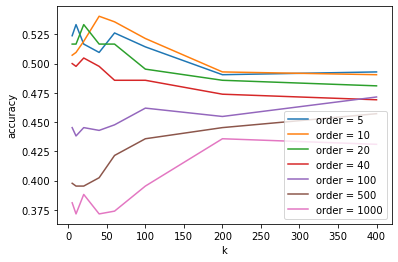

In [88]:
for i, r in enumerate(rs): 
    plt.plot(kvals, accuracies_all[i], label=f'order = {r}')
plt.xlabel('k')
plt.ylabel('accuracy')
plt.legend()

    

In [85]:
from sklearn.preprocessing import StandardScaler

def split_data_shuffle(nfigs, figs, classes, train_split=0.6, val_split=0.15, test_split=0.25, seed=0, return_S=False, scale=False, center=False):
    
    
    training_data = np.empty((int(n_classes*n_figs*train_split), 256*256))
    val_data = np.empty((int(n_classes*n_figs*val_split), 256*256))
    testing_data = np.empty((int(n_classes*n_figs*test_split), 256*256))

    training_labels=[]
    testing_labels=[]
    val_labels=[]

    b = -1
    c = -1
    d = -1
    
    np.random.seed(seed)
    rand_idx = np.random.permutation(int(n_figs*(train_split+val_split))) 
    #print(rand_idx)
    
    # separate testing, training, validation data                  
    for i in range(n_classes):
        for j in range(n_figs):
            if j < n_figs*train_split:
                b = b+1
                training_labels.append(classes[i])
                training_data[b,:] = figs[i][rand_idx[j]].flatten()

            elif j >= n_figs*train_split and j < n_figs*(train_split+val_split):
                c = c+1
                val_labels.append(classes[i])
                val_data[c,:] = figs[i][rand_idx[j]].flatten()

            elif j >= n_figs*(train_split+val_split):
                d = d+1
                #testing_labels[d] = classes[i]
                testing_labels.append(classes[i])
                testing_data[d,:] = figs[i][j].flatten()
                  
    print(f'training size: {training_data.shape[0]}')
    print(f'validation size: {val_data.shape[0]}')
    print(f'testing size: {testing_data.shape[0]}')            

    print(b,c,d)            
    print(training_data.shape)
    #print(training_labels)
    
    # center the snapshots
    #x_bar = np.mean(training_data, axis=0)
    
    #Scaling the input data prior to training
    if scale==True:
        scaler = StandardScaler().fit(training_data)
        training_data = scaler.transform(training_data);
        val_data = scaler.transform(val_data)
        testing_data = scaler.transform(testing_data)
    elif center==True:   
        training_data = training_data - x_bar
        val_data = val_data - x_bar - xbar
        testing_data = testing_data - xbar
    
    
    print('Computing SVD....')
    [U, S, VH] = np.linalg.svd(training_data, full_matrices=False)
    
    print('Done!')

    V = VH.T
    if return_S==False:
        return training_data, val_data, testing_data, training_labels, val_labels, testing_labels, V
    elif return_S==True:
        return training_data, val_data, testing_data, training_labels, val_labels, testing_labels, V, S

        

#[training_data, val_data, testing_data, training_labels, val_labels, testing_labels, V, S] = split_data_shuffle(n_figs, figs, classes, return_S=True)

0.5096261823313329
(1680, 65536)
[2.56279713e+05 8.88404878e+04 7.49927487e+04 ... 8.76058017e+02
 5.94380859e+02 4.36735671e-11]


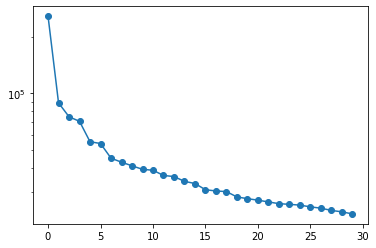

In [144]:
cenergy = np.sum(np.square(S[:10]))/np.sum(np.square(S))
print(cenergy)
print(training_data.shape)

print(S)

plt.semilogy(np.arange(30), S[:30], '-o')

In [98]:
rs = [5, 10, 40, 100, 500, 1000]
kvals = [5, 10, 20, 40, 60, 100, 200, 400]

accuracies_all = []
num_shuffles = 5

for n in range(num_shuffles):
    [training_data, val_data, testing_data, training_labels, val_labels, testing_labels, V] = split_data_shuffle(n_figs, figs, classes, seed=n)
    accuracies=[]
    for r in rs: 
        Vr = V[:,0:r]
        r_training_data = training_data @ Vr
        r_testing_data = testing_data @ Vr
        r_val_data = val_data @ Vr

        acc = np.empty((len(kvals)))
        for j, k in enumerate(kvals):
            n_correct = 0
            for i in range(r_val_data.shape[0]):
                p = knn(r_val_data[i], r_training_data, training_labels, k)
                #print(f'Prediction: {p[0][0]}, Truth: {testing_labels[i]} ')
                if p[0][0] == val_labels[i]:
                    n_correct = n_correct + 1
            print(f'r = {r}, k = {k}, validation accuracy: {n_correct/r_val_data.shape[0]}')
            acc[j]= n_correct/r_val_data.shape[0] 
            
        accuracies.append(acc)
        
    accuracies_all.append(accuracies)    

training size: 1680
validation size: 420
testing size: 700
1679 419 699
(1680, 65536)
Computing SVD....
Done!
r = 5, k = 5, validation accuracy: 0.5071428571428571
r = 5, k = 10, validation accuracy: 0.5142857142857142
r = 5, k = 20, validation accuracy: 0.5428571428571428
r = 5, k = 40, validation accuracy: 0.5380952380952381
r = 5, k = 60, validation accuracy: 0.5428571428571428
r = 5, k = 100, validation accuracy: 0.5119047619047619
r = 5, k = 200, validation accuracy: 0.5071428571428571
r = 5, k = 400, validation accuracy: 0.49523809523809526
r = 10, k = 5, validation accuracy: 0.5166666666666667
r = 10, k = 10, validation accuracy: 0.5238095238095238
r = 10, k = 20, validation accuracy: 0.5261904761904762
r = 10, k = 40, validation accuracy: 0.5380952380952381
r = 10, k = 60, validation accuracy: 0.5357142857142857
r = 10, k = 100, validation accuracy: 0.5238095238095238
r = 10, k = 200, validation accuracy: 0.5047619047619047
r = 10, k = 400, validation accuracy: 0.49047619047619

r = 1000, k = 60, validation accuracy: 0.4
r = 1000, k = 100, validation accuracy: 0.41904761904761906
r = 1000, k = 200, validation accuracy: 0.42857142857142855
r = 1000, k = 400, validation accuracy: 0.45
training size: 1680
validation size: 420
testing size: 700
1679 419 699
(1680, 65536)
Computing SVD....
Done!
r = 5, k = 5, validation accuracy: 0.49047619047619045
r = 5, k = 10, validation accuracy: 0.5547619047619048
r = 5, k = 20, validation accuracy: 0.5642857142857143
r = 5, k = 40, validation accuracy: 0.5476190476190477
r = 5, k = 60, validation accuracy: 0.55
r = 5, k = 100, validation accuracy: 0.5333333333333333
r = 5, k = 200, validation accuracy: 0.5285714285714286
r = 5, k = 400, validation accuracy: 0.4857142857142857
r = 10, k = 5, validation accuracy: 0.5023809523809524
r = 10, k = 10, validation accuracy: 0.5261904761904762
r = 10, k = 20, validation accuracy: 0.5452380952380952
r = 10, k = 40, validation accuracy: 0.5357142857142857
r = 10, k = 60, validation acc

In [99]:
avg_accuracies = []
for i in range(len(rs)):
    avg_acc = np.zeros(accuracies_all[0][0].shape)
    for n in range(num_shuffles):
        avg_acc = avg_acc + accuracies_all[n][i]
        #print(accuracies_all[n][i])
        #print(avg_acc)
    avg_acc = avg_acc/num_shuffles
    avg_accuracies.append(avg_acc)
    
#print(avg_accuracies)

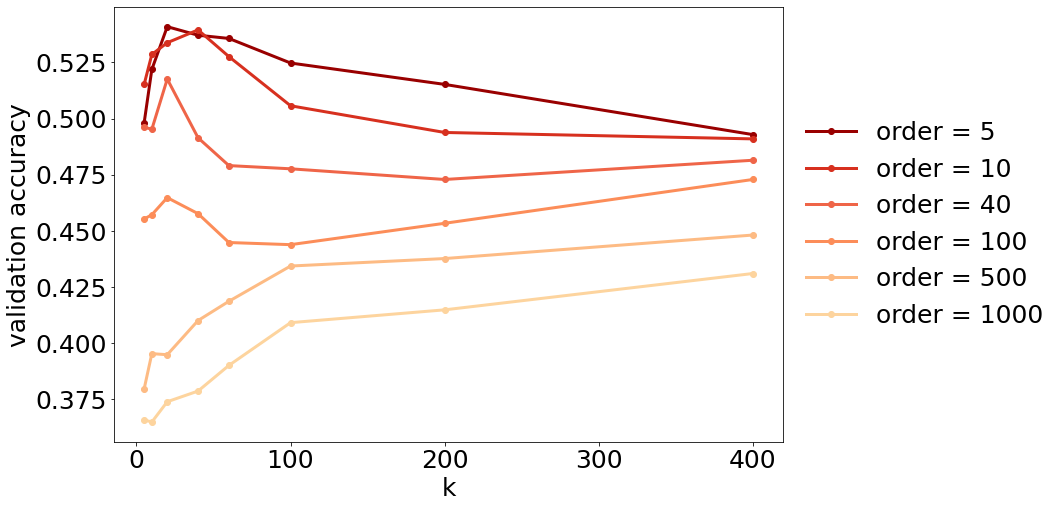

In [100]:
plt.rcParams["figure.figsize"] = (12,8)
plt.rcParams.update({'font.size': 25})

colors= ['#edf8fb', '#bfd3e6', '#9ebcda', '#8c96c6', '#8c6bb1', '#88419d', '#6e016b']
colors = ['#fdd49e','#fdbb84','#fc8d59','#ef6548','#d7301f','#990000']
colors.reverse()

for i, r in enumerate(rs): 
    plt.plot(kvals, avg_accuracies[i], '-o', lw=3.0, label=f'order = {r}', color=colors[i])
plt.xlabel('k')
plt.ylabel('validation accuracy')
plt.legend(loc='center left', bbox_to_anchor=(1,0.5), frameon=False)

plt.savefig('./knn_hp_selection.png', format='png',bbox_inches='tight',dpi=300)   



In [ ]:
# get best parameters 

r_best = 5
k_best = 20

# compute the test performance 

[training_data, val_data, testing_data, training_labels, val_labels, testing_labels, V] = split_data_shuffle(n_figs, figs, classes, seed=0)

Vr = V[:,0:r_best]
r_training_data = training_data @ Vr
r_testing_data = testing_data @ Vr
r_val_data = val_data @ Vr

scaler = StandardScaler().fit(r_training_data)
r_training_data = scaler.transform(r_training_data);
r_val_data = scaler.transform(r_val_data)
r_testing_data = scaler.transform(r_testing_data)

acc = np.empty((len(kvals)))
n_correct = 0
testing_predictions =[]
correct_bool = np.zeros(len(testing_labels))
for i in range(r_testing_data.shape[0]):
    p = knn(r_testing_data[i], r_training_data, training_labels, k_best)          
    testing_predictions.append(p[0][0])
    if p[0][0] == testing_labels[i]:
        n_correct = n_correct + 1
        correct_bool[i]=1
        
print(f'r = {r_best}, k = {k_best}, testing accuracy: {n_correct/r_testing_data.shape[0]}')
test_accuracy = n_correct/r_testing_data.shape[0]

training size: 1680
validation size: 420
testing size: 700
1679 419 699
(1680, 65536)
Computing SVD....
Done!


0 175
175 350
350 525
525 700
[0.36950146627565983, 0.31085043988269795, 0.16715542521994134, 0.15249266862170088]


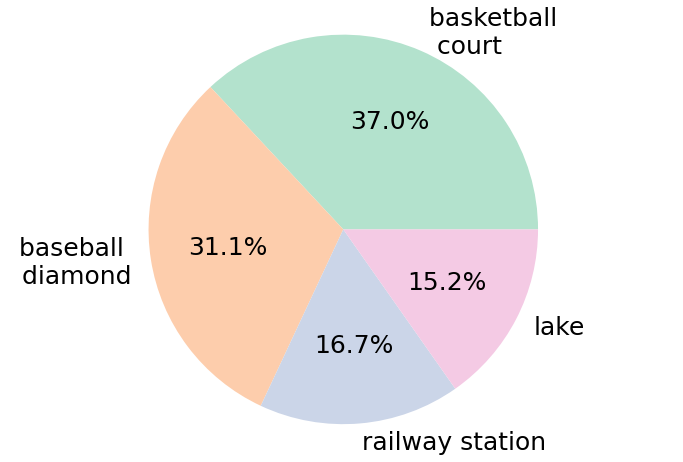

In [72]:
# pie chart of misclassifications 


c = Counter(testing_labels)
c2 = Counter(testing_predictions)

inds = np.arange(0,5)*175

mc = []
for i in range(4):
    print(inds[i], inds[i+1])
    #print(correct_bool[inds[i]:inds[i+1]])
    e = 175- np.sum(correct_bool[inds[i]:inds[i+1]])
    mc.append(e/(700-n_correct))
print(mc)

colors = ['#b3e2cd', '#fdcdac', '#cbd5e8', '#f4cae4']
    
labels = ['basketball \n court', 'baseball \n diamond', 'railway station', 'lake']    
fig1, ax1 = plt.subplots()
ax1.pie(mc, autopct='%1.1f%%', labels=labels, colors = colors)
ax1.axis('equal')
plt.show()

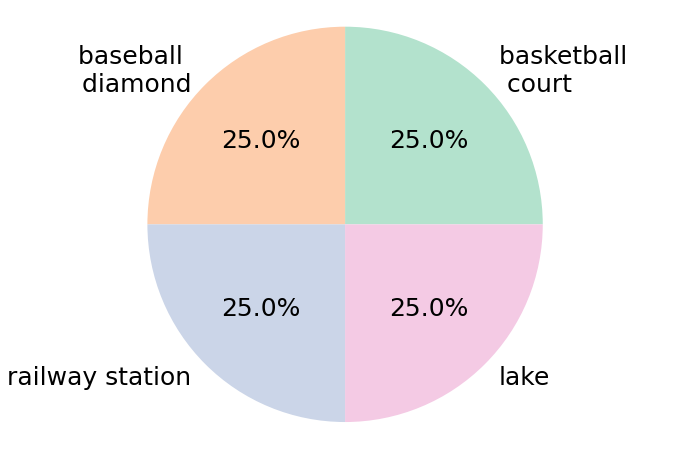

In [73]:
fig2, ax2 = plt.subplots()
ax2.pie([25, 25, 25, 25], autopct='%1.1f%%', labels=labels, colors = colors)
ax2.axis('equal')
plt.show()

# use centering and scaling

In [75]:
rs = [5, 10, 40, 100, 500, 1000]
kvals = [5, 10, 20, 40, 60, 100, 200, 400]

accuracies_all = []
num_shuffles = 5

for n in range(num_shuffles):
    [training_data, val_data, testing_data, training_labels, val_labels, testing_labels, V] = split_data_shuffle(n_figs, figs, classes, seed=n, scale=True)
    accuracies=[]
    for r in rs: 
        Vr = V[:,0:r]
        r_training_data = training_data @ Vr
        r_testing_data = testing_data @ Vr
        r_val_data = val_data @ Vr

        acc = np.empty((len(kvals)))
        for j, k in enumerate(kvals):
            n_correct = 0
            for i in range(r_val_data.shape[0]):
                p = knn(r_val_data[i], r_training_data, training_labels, k)
                #print(f'Prediction: {p[0][0]}, Truth: {testing_labels[i]} ')
                if p[0][0] == val_labels[i]:
                    n_correct = n_correct + 1
            print(f'r = {r}, k = {k}, validation accuracy: {n_correct/r_val_data.shape[0]}')
            acc[j]= n_correct/r_val_data.shape[0] 
            
        accuracies.append(acc)
        
    accuracies_all.append(accuracies)    

training size: 1680
validation size: 420
testing size: 700
1679 419 699
(1680, 65536)
Computing SVD....
Done!
r = 5, k = 5, validation accuracy: 0.5023809523809524
r = 5, k = 10, validation accuracy: 0.5285714285714286
r = 5, k = 20, validation accuracy: 0.5380952380952381
r = 5, k = 40, validation accuracy: 0.5380952380952381
r = 5, k = 60, validation accuracy: 0.5380952380952381
r = 5, k = 100, validation accuracy: 0.5
r = 5, k = 200, validation accuracy: 0.49047619047619045
r = 5, k = 400, validation accuracy: 0.4928571428571429
r = 10, k = 5, validation accuracy: 0.5119047619047619
r = 10, k = 10, validation accuracy: 0.5261904761904762
r = 10, k = 20, validation accuracy: 0.55
r = 10, k = 40, validation accuracy: 0.55
r = 10, k = 60, validation accuracy: 0.5404761904761904
r = 10, k = 100, validation accuracy: 0.5142857142857142
r = 10, k = 200, validation accuracy: 0.49523809523809526
r = 10, k = 400, validation accuracy: 0.4880952380952381
r = 40, k = 5, validation accuracy: 0.5

r = 1000, k = 100, validation accuracy: 0.4095238095238095
r = 1000, k = 200, validation accuracy: 0.4238095238095238
r = 1000, k = 400, validation accuracy: 0.45476190476190476
training size: 1680
validation size: 420
testing size: 700
1679 419 699
(1680, 65536)
Computing SVD....
Done!
r = 5, k = 5, validation accuracy: 0.5119047619047619
r = 5, k = 10, validation accuracy: 0.5452380952380952
r = 5, k = 20, validation accuracy: 0.5452380952380952
r = 5, k = 40, validation accuracy: 0.569047619047619
r = 5, k = 60, validation accuracy: 0.5452380952380952
r = 5, k = 100, validation accuracy: 0.5261904761904762
r = 5, k = 200, validation accuracy: 0.5023809523809524
r = 5, k = 400, validation accuracy: 0.48095238095238096
r = 10, k = 5, validation accuracy: 0.5071428571428571
r = 10, k = 10, validation accuracy: 0.5357142857142857
r = 10, k = 20, validation accuracy: 0.5476190476190477
r = 10, k = 40, validation accuracy: 0.5238095238095238
r = 10, k = 60, validation accuracy: 0.52619047

In [76]:

avg_accuracies = []
for i in range(len(rs)):
    avg_acc = np.zeros(accuracies_all[0][0].shape)
    for n in range(num_shuffles):
        avg_acc = avg_acc + accuracies_all[n][i]
        #print(accuracies_all[n][i])
        #print(avg_acc)
    avg_acc = avg_acc/num_shuffles
    avg_accuracies.append(avg_acc)
    
#print(avg_accuracies)

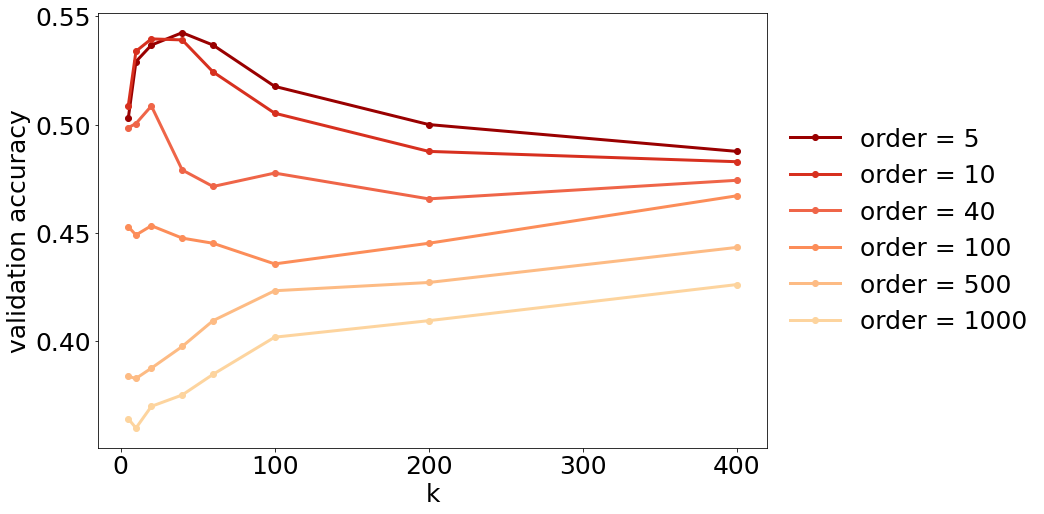

In [77]:
plt.rcParams["figure.figsize"] = (12,8)
plt.rcParams.update({'font.size': 25})

colors= ['#edf8fb', '#bfd3e6', '#9ebcda', '#8c96c6', '#8c6bb1', '#88419d', '#6e016b']
colors = ['#fdd49e','#fdbb84','#fc8d59','#ef6548','#d7301f','#990000']
colors.reverse()

for i, r in enumerate(rs): 
    plt.plot(kvals, avg_accuracies[i], '-o', lw=3.0, label=f'order = {r}', color=colors[i])
plt.xlabel('k')
plt.ylabel('validation accuracy')
plt.legend(loc='center left', bbox_to_anchor=(1,0.5), frameon=False)

plt.savefig('./knn_hp_selection.png', format='png',bbox_inches='tight',dpi=300)   



In [87]:
# get best parameters 

r_best = 5
k_best = 40

# compute the test performance 

[training_data, val_data, testing_data, training_labels, val_labels, testing_labels, V] = split_data_shuffle(n_figs, figs, classes, seed=0, scale=True)

Vr = V[:,0:r_best]
r_training_data = training_data @ Vr
r_testing_data = testing_data @ Vr
r_val_data = val_data @ Vr

acc = np.empty((len(kvals)))
n_correct = 0
testing_predictions =[]
correct_bool = np.zeros(len(testing_labels))
for i in range(r_testing_data.shape[0]):
    p = knn(r_testing_data[i], r_training_data, training_labels, k_best)          
    testing_predictions.append(p[0][0])
    if p[0][0] == testing_labels[i]:
        n_correct = n_correct + 1
        correct_bool[i]=1
        
print(f'r = {r_best}, k = {k_best}, testing accuracy: {n_correct/r_testing_data.shape[0]}')
test_accuracy = n_correct/r_testing_data.shape[0]

training size: 1680
validation size: 420
testing size: 700
1679 419 699
(1680, 65536)
Computing SVD....
Done!
r = 5, k = 40, testing accuracy: 0.5328571428571428


0 175
175 350
350 525
525 700
[0.36950146627565983, 0.31085043988269795, 0.16715542521994134, 0.15249266862170088]


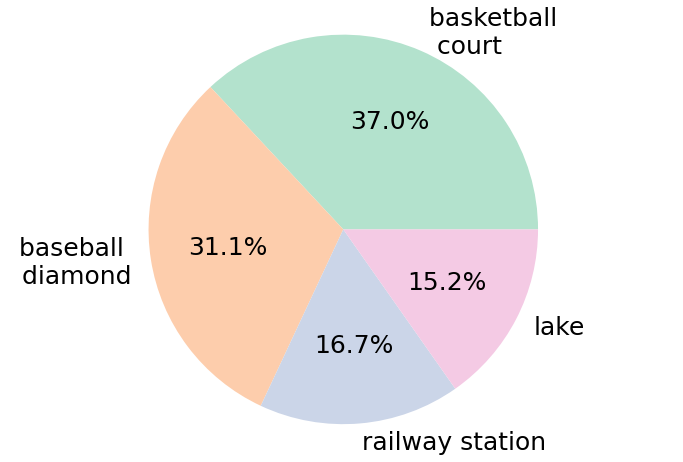

In [72]:
# pie chart of misclassifications 


c = Counter(testing_labels)
c2 = Counter(testing_predictions)

inds = np.arange(0,5)*175

mc = []
for i in range(4):
    print(inds[i], inds[i+1])
    #print(correct_bool[inds[i]:inds[i+1]])
    e = 175- np.sum(correct_bool[inds[i]:inds[i+1]])
    mc.append(e/(700-n_correct))
print(mc)

colors = ['#b3e2cd', '#fdcdac', '#cbd5e8', '#f4cae4']
    
labels = ['basketball \n court', 'baseball \n diamond', 'railway station', 'lake']    
fig1, ax1 = plt.subplots()
ax1.pie(mc, autopct='%1.1f%%', labels=labels, colors = colors)
ax1.axis('equal')
plt.show()

    
    
